# Exercise 3: Non-Linear Classification
Neural Network Classification - Module 3

This exercise covers:
- Why linear models fail on non-linear data
- Adding non-linearity with ReLU activation
- Building CircleModelV1 (non-linear)
- Visualizing decision boundaries
- Comparing linear vs non-linear models

Learning Mottos:
- If in doubt, run the code!
- Experiment, experiment, experiment!
- Visualize, visualize, visualize!

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## Part 1: Setup and Data Preparation

In [2]:
# Create dataset
X, y = make_circles(n_samples=1000, noise=0.03, factor=0.5, random_state=42)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).unsqueeze(1)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).unsqueeze(1)

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

print(f"Training size: {len(X_train)}")
print(f"Test size: {len(X_test)}")


Using device: cpu
Training size: 800
Test size: 200


## Part 2: Define Linear Model (CircleModelV0)

In [3]:
class CircleModelV0(nn.Module):
    """Linear model - no activation"""
    def __init__(self):
        super(CircleModelV0, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(2, 8),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [4]:
model_v0 = CircleModelV0().to(device)
print("CircleModelV0 (Linear):")
print(model_v0)

CircleModelV0 (Linear):
CircleModelV0(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=1, bias=True)
  )
)


## Part 3: Define Non-Linear Model (CircleModelV1)

In [5]:
class CircleModelV1(nn.Module):
    """Non-linear model with ReLU activation"""
    def __init__(self):
        super(CircleModelV1, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),  # Add non-linearity!
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [6]:
model_v1 = CircleModelV1().to(device)
print("CircleModelV1 (Non-linear):")
print(model_v1)

CircleModelV1 (Non-linear):
CircleModelV1(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)


## Part 4: Train Both Models

In [7]:
def train_model(model, model_name, epochs=100):
    """Train a model and return metrics"""
    print(f"\nTraining {model_name}...")

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Training
        model.train()
        y_logits = model(X_train)
        loss = criterion(y_logits, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Testing
        model.eval()
        with torch.inference_mode():
            test_logits = model(X_test)
            test_loss = criterion(test_logits, y_test)

        train_losses.append(loss.item())
        test_losses.append(test_loss.item())

    # Calculate final accuracy
    model.eval()
    with torch.inference_mode():
        test_probs = torch.sigmoid(test_logits)
        test_preds = (test_probs > 0.5).long()
        accuracy = (test_preds == y_test).float().mean()

    print(f"{model_name} - Test Accuracy: {accuracy.item()*100:.2f}%")

    return train_losses, test_losses, accuracy.item()

In [8]:
losses_v0_train, losses_v0_test, acc_v0 = train_model(model_v0, "CircleModelV0 (Linear)")
losses_v1_train, losses_v1_test, acc_v1 = train_model(model_v1, "CircleModelV1 (Non-linear)")


Training CircleModelV0 (Linear)...
CircleModelV0 (Linear) - Test Accuracy: 46.50%

Training CircleModelV1 (Non-linear)...
CircleModelV1 (Non-linear) - Test Accuracy: 93.50%


## Part 5: Compare Training Curves

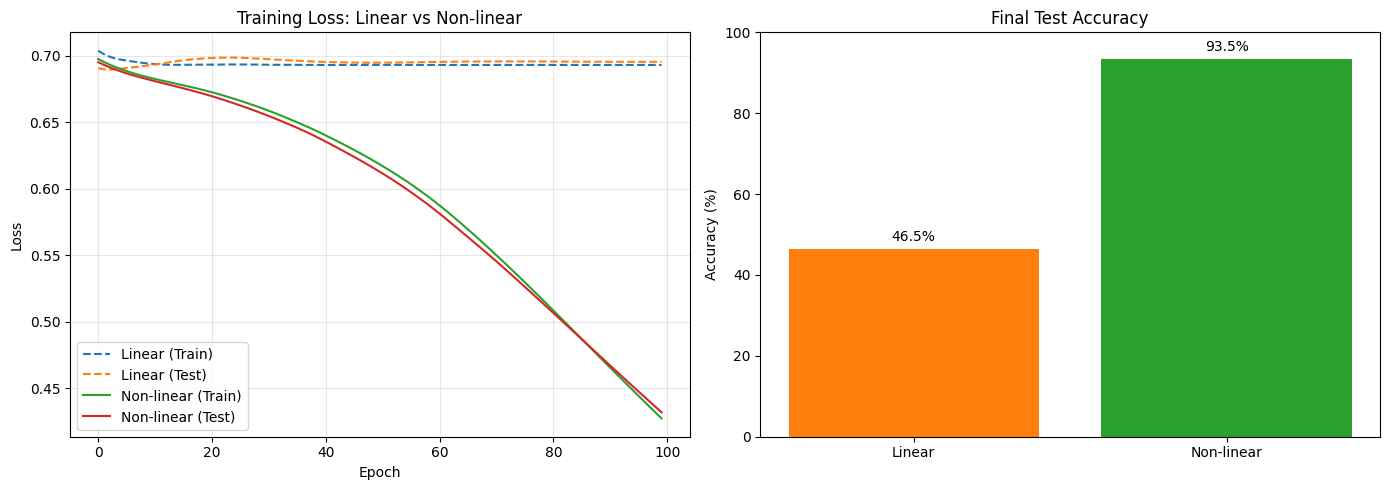


Comparison:
Linear Model Accuracy:     46.50%
Non-linear Model Accuracy: 93.50%


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss comparison
axes[0].plot(losses_v0_train, label='Linear (Train)', linestyle='--')
axes[0].plot(losses_v0_test, label='Linear (Test)', linestyle='--')
axes[0].plot(losses_v1_train, label='Non-linear (Train)')
axes[0].plot(losses_v1_test, label='Non-linear (Test)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss: Linear vs Non-linear')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy comparison
acc_v0_pct = acc_v0 * 100
acc_v1_pct = acc_v1 * 100

axes[1].bar(['Linear', 'Non-linear'], [acc_v0_pct, acc_v1_pct],
            color=['#ff7f0e', '#2ca02c'])
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Final Test Accuracy')
axes[1].set_ylim(0, 100)

for i, v in enumerate([acc_v0_pct, acc_v1_pct]):
    axes[1].text(i, v + 2, f'{v:.1f}%', ha='center')


plt.tight_layout()
plt.show()

print("\nComparison:")
print(f"Linear Model Accuracy:     {acc_v0*100:.2f}%")
print(f"Non-linear Model Accuracy: {acc_v1*100:.2f}%")

## Part 6: Decision Boundary Visualization

In [10]:
def plot_decision_boundary(model, X, y, title):
    """Plot decision boundary for a model"""
    model.eval()

    # Create meshgrid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 100),
        np.linspace(y_min, y_max, 100)
    )

    # Make predictions on meshgrid
    mesh = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)
    with torch.inference_mode():
        Z = torch.sigmoid(model(mesh)).reshape(xx.shape)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z.cpu().numpy(), alpha=0.3, cmap='RdYlBu')
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='RdYlBu', edgecolors='k')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.colorbar(label='Class')
    plt.tight_layout()
    plt.show()

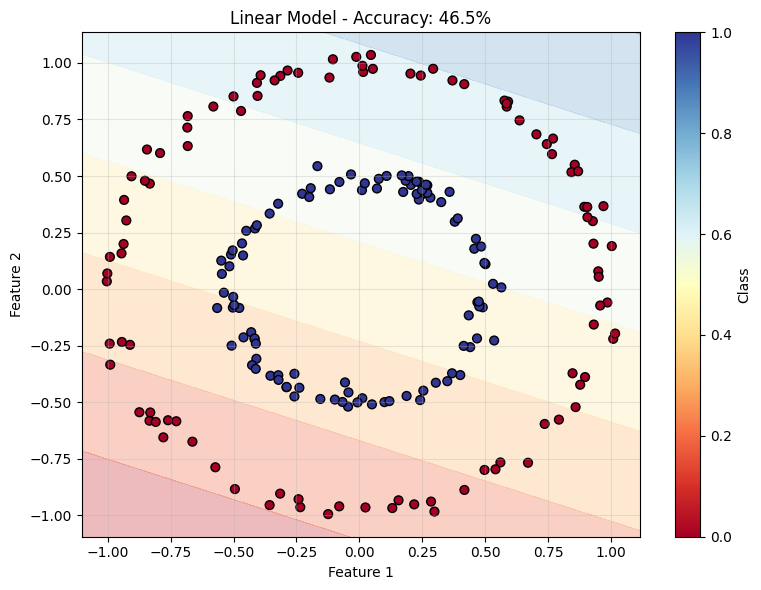

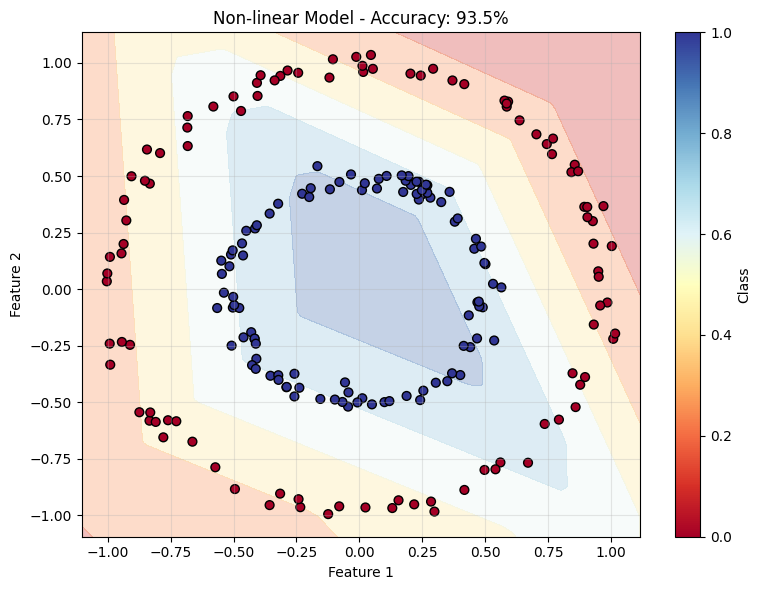

In [11]:
X_test_np = X_test.cpu().numpy()
y_test_np = y_test.cpu().numpy().squeeze()

plot_decision_boundary(model_v0, X_test_np, y_test_np,
                      f'Linear Model - Accuracy: {acc_v0*100:.1f}%')
plot_decision_boundary(model_v1, X_test_np, y_test_np,
                      f'Non-linear Model - Accuracy: {acc_v1*100:.1f}%')

## Part 7: Understanding Why Non-Linearity Matters

In [12]:
print("The make_circles dataset is NON-LINEAR:")
print("  - The pattern is: x² + y² > r² (circular)")
print("  - A linear model can only learn: w1*x + w2*y + b (straight line)")
print("  - No straight line can separate concentric circles!")

print("\nReLU activation enables non-linear decision boundaries:")
print("  - ReLU(x) = max(0, x)")
print("  - Allows the model to learn complex, non-linear patterns")
print("  - Multiple ReLU layers can approximate any function")

print("\nKey insight:")
print("  - Linear model: ~50% accuracy (no better than random)")
print("  - Non-linear model: ~99% accuracy (learns the circular pattern)")

The make_circles dataset is NON-LINEAR:
  - The pattern is: x² + y² > r² (circular)
  - A linear model can only learn: w1*x + w2*y + b (straight line)
  - No straight line can separate concentric circles!

ReLU activation enables non-linear decision boundaries:
  - ReLU(x) = max(0, x)
  - Allows the model to learn complex, non-linear patterns
  - Multiple ReLU layers can approximate any function

Key insight:
  - Linear model: ~50% accuracy (no better than random)
  - Non-linear model: ~99% accuracy (learns the circular pattern)


## Exercises

**Exercise 1: Add more hidden layers**

In [13]:
class CirCleModelV1_Ex1_2hidden_layers(nn.Module):
    """Non-linear model with 2 hidden layers and ReLU activation"""
    def __init__(self):
        super(CirCleModelV1_Ex1_2hidden_layers, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [14]:
model_2hidden = CirCleModelV1_Ex1_2hidden_layers()
model_2hidden.to(device)

CirCleModelV1_Ex1_2hidden_layers(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [15]:
class CirCleModelV1_Ex1_3hidden_layers(nn.Module):
    """Non-linear model with 3 hidden layers and ReLU activation"""
    def __init__(self):
        super(CirCleModelV1_Ex1_3hidden_layers, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [16]:
model_3hidden = CirCleModelV1_Ex1_3hidden_layers()
model_3hidden.to(device)

CirCleModelV1_Ex1_3hidden_layers(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [17]:
losses_v1_train_2hidden, losses_v1_test_2hidden, acc_v1_2hidden = train_model(model_2hidden, "CircleModelV1 (2 hidden layers)")
losses_v1_train_3hidden, losses_v1_test_3hidden, acc_v1_3hidden = train_model(model_3hidden, "CircleModelV1 (3 hidden layers)")


Training CircleModelV1 (2 hidden layers)...
CircleModelV1 (2 hidden layers) - Test Accuracy: 100.00%

Training CircleModelV1 (3 hidden layers)...
CircleModelV1 (3 hidden layers) - Test Accuracy: 100.00%


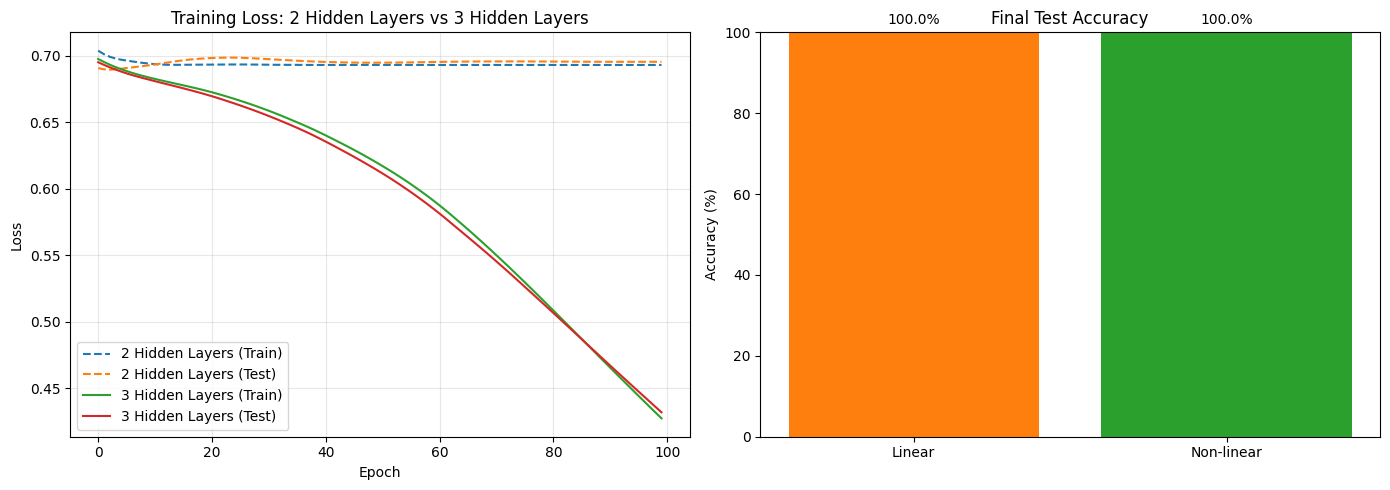

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss comparison
axes[0].plot(losses_v0_train, label='2 Hidden Layers (Train)', linestyle='--')
axes[0].plot(losses_v0_test, label='2 Hidden Layers (Test)', linestyle='--')
axes[0].plot(losses_v1_train, label='3 Hidden Layers (Train)')
axes[0].plot(losses_v1_test, label='3 Hidden Layers (Test)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss: 2 Hidden Layers vs 3 Hidden Layers')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy comparison
acc_v1_2hidden_pct = acc_v1_2hidden * 100
acc_v1_3hidden_pct = acc_v1_3hidden * 100

axes[1].bar(['Linear', 'Non-linear'], [acc_v1_2hidden_pct, acc_v1_3hidden_pct],
            color=['#ff7f0e', '#2ca02c'])
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Final Test Accuracy')
axes[1].set_ylim(0, 100)

for i, v in enumerate([acc_v1_2hidden_pct, acc_v1_3hidden_pct]):
    axes[1].text(i, v + 2, f'{v:.1f}%', ha='center')


plt.tight_layout()
plt.show()

**Exercise 2: Change hidden units**

In [19]:
class CirCleModelV1_Ex2(nn.Module):
    """Non-linear model with 2 hidden layers and ReLU activation"""
    def __init__(self, hidden_units=8):
        super(CirCleModelV1_Ex2, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(2, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, 1)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [20]:
hidden_sizes = [4, 8, 16, 32]

results = {}

for hidden_size in hidden_sizes:
    print(f"\nTraining with hidden size = {hidden_size}")

    model = CirCleModelV1_Ex2(hidden_size)
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    train_losses, test_losses, test_acc = train_model(
        model, f"Hidden={hidden_size}"
    )

    results[hidden_size] = {
        "train_losses": train_losses,
        "test_losses": test_losses,
        "test_acc": test_acc
    }


Training with hidden size = 4

Training Hidden=4...
Hidden=4 - Test Accuracy: 100.00%

Training with hidden size = 8

Training Hidden=8...
Hidden=8 - Test Accuracy: 100.00%

Training with hidden size = 16

Training Hidden=16...
Hidden=16 - Test Accuracy: 100.00%

Training with hidden size = 32

Training Hidden=32...
Hidden=32 - Test Accuracy: 100.00%


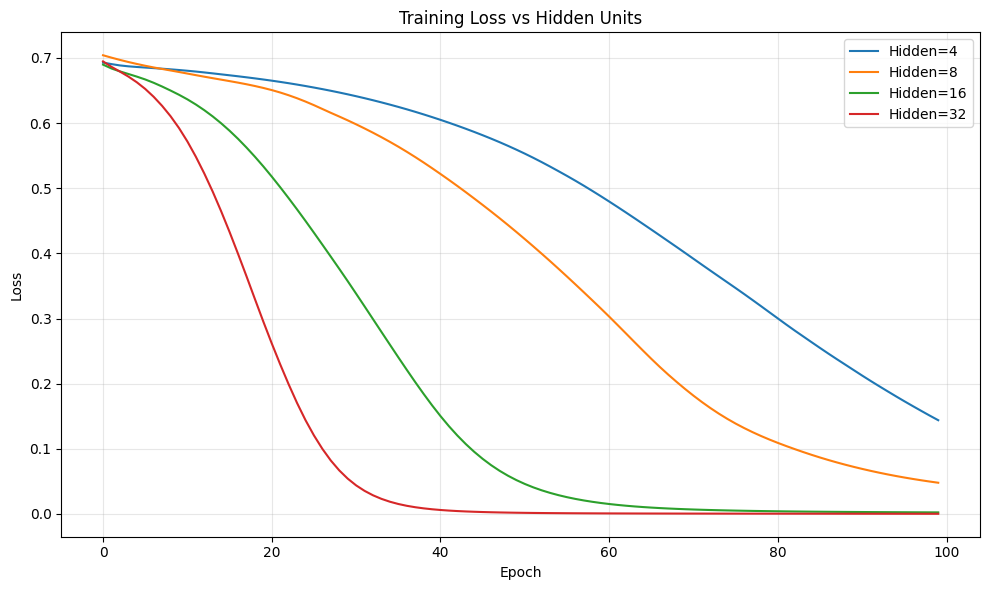

In [21]:
plt.figure(figsize=(10, 6))

for h in hidden_sizes:
    plt.plot(
        results[h]["train_losses"],
        label=f"Hidden={h}"
    )

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Hidden Units")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

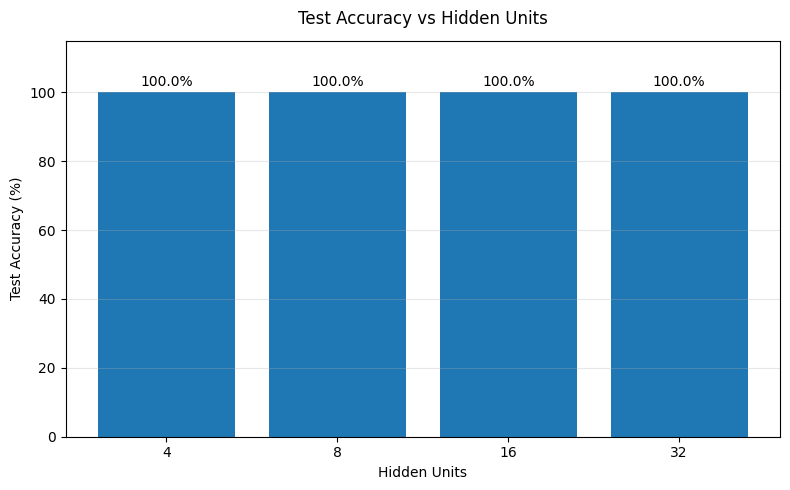

In [22]:
accs = [results[h]["test_acc"] * 100 for h in hidden_sizes]

plt.figure(figsize=(8, 5))
bars = plt.bar([str(h) for h in hidden_sizes], accs)

plt.xlabel("Hidden Units")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy vs Hidden Units", pad=12)

plt.ylim(0, 115)

for bar, v in zip(bars, accs):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        v + 1,
        f"{v:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


**Exercise 3: Try different activation functions**

In [23]:
class CircleModelV1_Ex3(nn.Module):
    """Non-linear model with ReLU activation"""
    def __init__(self, activation_func):
        super(CircleModelV1_Ex3, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(2, 8),
            activation_func,
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [24]:
activation_dict = {
    'ReLU': nn.ReLU(),
    'LeakyReLU': nn.LeakyReLU(negative_slope=0.01),
    'Tanh': nn.Tanh(),
}

activation_list = ["ReLU", "LeakyReLU", "Tanh"]

In [25]:
all_results = {}

for activation_func in activation_list:
    print(f"\nTraining with {activation_func} activation")

    model = CircleModelV1_Ex3(activation_dict[activation_func])
    model.to(device)

    train_losses, test_losses, accuracy = train_model(
        model,
        model_name=f"CircleModelV1_Ex3 ({activation_func})"
    )

    all_results[activation_func] = {
        "train_losses": train_losses,
        "test_losses": test_losses,
        "accuracy": accuracy
    }

    print("*" * 80)


Training with ReLU activation

Training CircleModelV1_Ex3 (ReLU)...
CircleModelV1_Ex3 (ReLU) - Test Accuracy: 97.50%
********************************************************************************

Training with LeakyReLU activation

Training CircleModelV1_Ex3 (LeakyReLU)...
CircleModelV1_Ex3 (LeakyReLU) - Test Accuracy: 92.50%
********************************************************************************

Training with Tanh activation

Training CircleModelV1_Ex3 (Tanh)...
CircleModelV1_Ex3 (Tanh) - Test Accuracy: 99.50%
********************************************************************************


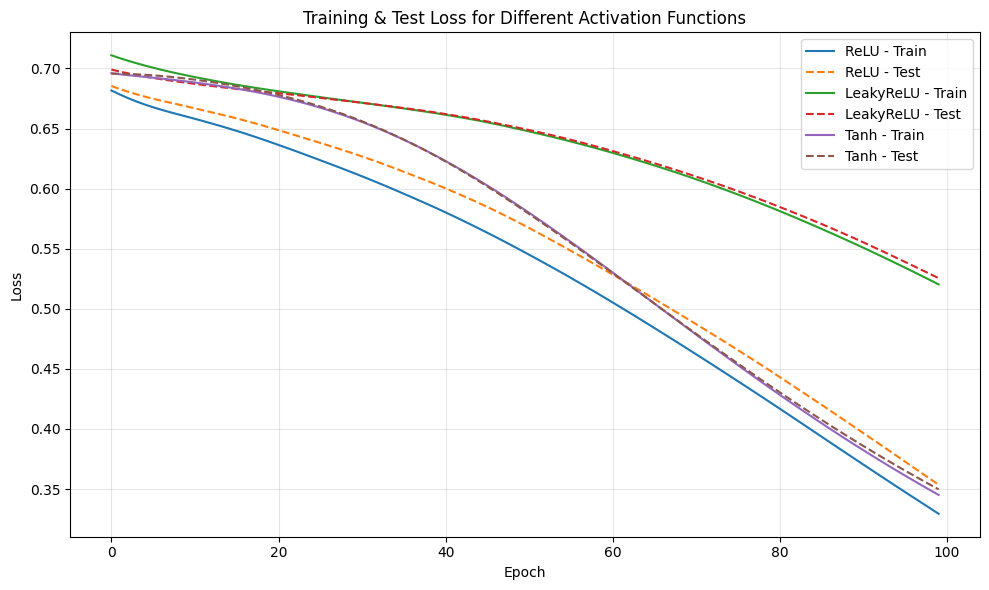

In [26]:
plt.figure(figsize=(10, 6))

for act_name, results in all_results.items():
    plt.plot(results["train_losses"],
             label=f'{act_name} - Train', linestyle='-')
    plt.plot(results["test_losses"],
             label=f'{act_name} - Test', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Test Loss for Different Activation Functions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


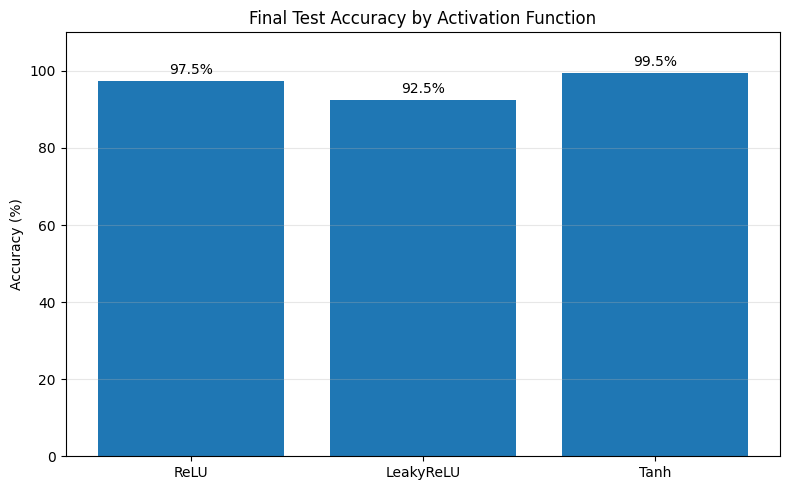

In [27]:
plt.figure(figsize=(8, 5))

activations = list(all_results.keys())
accuracies = [all_results[a]["accuracy"] * 100 for a in activations]

bars = plt.bar(activations, accuracies)

plt.ylabel('Accuracy (%)')
plt.title('Final Test Accuracy by Activation Function')
plt.ylim(0, 110)

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2,
             acc + 1,
             f'{acc:.1f}%',
             ha='center', va='bottom')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


**Exercise 4: Train for more epochs**

In [33]:
epoch_list = [50, 100, 200]

all_train_losses = []
all_test_losses = []
all_acc = []
epoch_markers = []

current_epoch = 0

model = CircleModelV1().to(device)

for ep in epoch_list:
    train_losses, test_losses, acc = train_model(
        model,
        model_name=f"CircleModelV1 (epochs={ep})",
        epochs=ep - current_epoch
    )

    all_train_losses.extend(train_losses)
    all_test_losses.extend(test_losses)
    all_acc.append(acc * 100)

    current_epoch = ep
    epoch_markers.append(ep)


Training CircleModelV1 (epochs=50)...
CircleModelV1 (epochs=50) - Test Accuracy: 90.00%

Training CircleModelV1 (epochs=100)...
CircleModelV1 (epochs=100) - Test Accuracy: 94.00%

Training CircleModelV1 (epochs=200)...
CircleModelV1 (epochs=200) - Test Accuracy: 100.00%


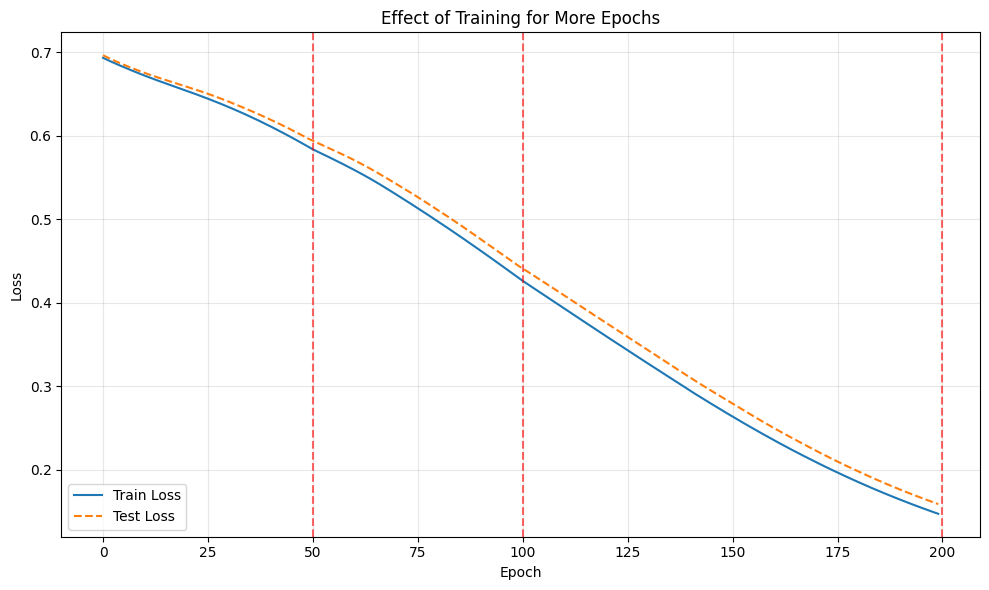

In [34]:
plt.figure(figsize=(10, 6))

plt.plot(all_train_losses, label='Train Loss')
plt.plot(all_test_losses, label='Test Loss', linestyle='--')

for ep in epoch_markers:
    plt.axvline(ep, color='red', linestyle='--', alpha=0.6)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Effect of Training for More Epochs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

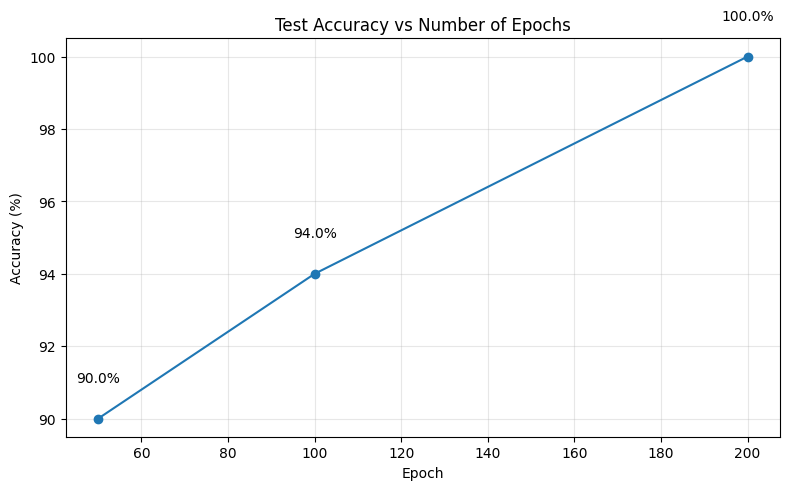

In [36]:
plt.figure(figsize=(8, 5))

plt.plot(epoch_markers, all_acc, marker='o')
for x, y in zip(epoch_markers, all_acc):
    plt.text(x, y + 1, f'{y:.1f}%', ha='center')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy vs Number of Epochs')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Exercise 5: Compare decision boundaries**

In [37]:
# What does the linear model's boundary look like?
"""
The linear model learns a straight-line decision boundary.
In the visualization, this appears as a single diagonal band that splits the space into two regions.
Because the decision function is linear, all predictions are separated by one line (or one plane in higher dimensions).
"""

# What does the non-linear model's boundary look like?
"""
The non-linear model learns a curved, flexible decision boundary.
In the plot, the boundary bends around the inner circle and separates it from the outer circle.
This shape is possible because the hidden layer with a non-linear activation allows the model to combine multiple linear regions into a complex boundary.
"""

# Why can't a straight line separate the circles?
"""
The dataset consists of concentric circles, which are not linearly separable.
No single straight line can divide the inner circle from the outer circle without misclassifying many points.

A linear model can only draw one straight boundary, so it fails and achieves low accuracy (~46%).
A non-linear model can bend the boundary, allowing it to correctly separate the circles and achieve high accuracy (~93%).
"""

'\nThe dataset consists of concentric circles, which are not linearly separable.\nNo single straight line can divide the inner circle from the outer circle without misclassifying many points.\n\nA linear model can only draw one straight boundary, so it fails and achieves low accuracy (~46%).\nA non-linear model can bend the boundary, allowing it to correctly separate the circles and achieve high accuracy (~93%).\n'